In [1]:
import warnings

In [2]:
warnings.filterwarnings('ignore')

✅Start by importing all the necessary libraries and modules.

In [3]:
import numpy as np
import pandas as pd

from scipy.stats import shapiro, normaltest

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import root_mean_squared_error

✅Perform some EDA and handle missing values.

In [4]:
data = pd.read_csv('train.csv')

In [5]:
data.shape

(1460, 81)

In [6]:
data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
data.drop(['Id'], axis=1, inplace=True)

In [8]:
data.isna().any().any()

True

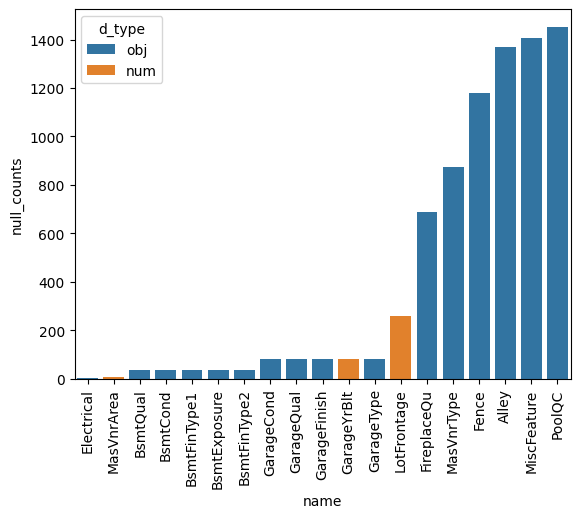

In [9]:
nulls = {'name': [], 'null_counts': [], 'd_type': []}

for column in data.columns:
    if data[column].isna().any():
        nulls['name'].append(column)
        nulls['null_counts'].append(data[column].isna().sum())
        nulls['d_type'].append('obj' if column in data.select_dtypes('object').columns else 'num')

nulls = pd.DataFrame(nulls)
nulls.sort_values(by=['null_counts'], inplace=True)
sns.barplot(x=nulls['name'], y=nulls['null_counts'], hue=nulls['d_type'])
plt.xticks(rotation=90)
plt.show()

In [10]:
nulls_to_drop = [column for column in nulls['name'] if column in list(nulls.where(nulls['null_counts'] > 400)['name'])]
nulls_to_drop

['FireplaceQu', 'MasVnrType', 'Fence', 'Alley', 'MiscFeature', 'PoolQC']

In [11]:
data.drop(nulls_to_drop, axis=1, inplace=True)

In [12]:
nulls_num = [column for column in nulls['name'] 
                if column in list(nulls.where(nulls['d_type'] == 'num')['name']) and
                column not in nulls_to_drop]
nulls_obj = [column for column in nulls['name']
                if column in list(nulls.where(nulls['d_type'] == 'obj')['name']) and
                column not in nulls_to_drop]

for column in nulls_num:
    data[column].fillna(value=data[column].median(), inplace=True)

for column in nulls_obj:
    data[column].fillna(value=data[column].mode()[0], inplace=True)

In [13]:
data.isna().any().any()

False

✅Observe the target and its dissemination.

In [14]:
target = data['SalePrice']
data.drop(['SalePrice'], axis=1, inplace=True)

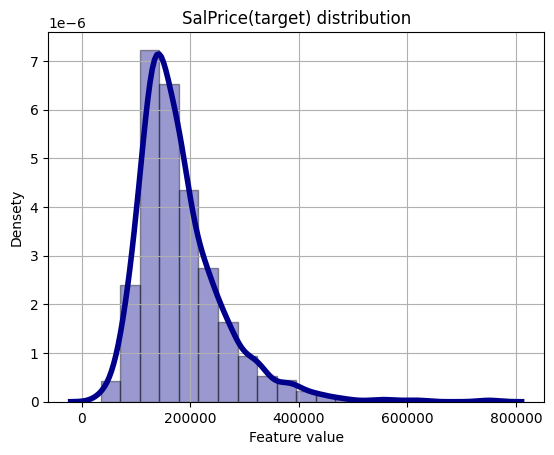

In [15]:
sns.distplot(target, hist=True, kde=True,
             bins=20, color='darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.xlabel('Feature value')
plt.ylabel('Densety')
plt.title('SalPrice(target) distribution')
plt.grid(True)
plt.show()

✅Verify the assumptions about the normal distribution based on a few standards.

In [16]:
# do Shapiro-Wilk test
statistic, pvalue = shapiro(target)
print(f'Statistic: {statistic:.3f}, p-value: {pvalue:.3f}')

Statistic: 0.870, p-value: 0.000


In [17]:
# do Kolmogorov-Smirnov test
statistic, pvalue = normaltest(target)
print(f'Statistic: {statistic:.3f}, p-value: {pvalue:.3f}')

Statistic: 610.836, p-value: 0.000


✅So yes, it is not normal distribution(p-value < 0.05)

✅Build dummy and boosting models.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=30)

In [19]:
# baseline model - dummy regressor
steps = [
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('regressor', DummyRegressor())
]

dummy = Pipeline(steps)
dummy.fit(X_train, y_train)
print('Dummy RMSE: ', root_mean_squared_error(y_test, dummy.predict(X_test)))
print('Dummy R2-score: ', dummy.score(X_test, y_test))

Dummy RMSE:  86005.13916414435
Dummy R2-score:  -0.004601382961449518


In [20]:
# clear boosting model
steps = [
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('regressor', GradientBoostingRegressor(verbose=100,
                                            n_estimators=2500,
                                            learning_rate=0.02,
                                            max_depth=6)
                                           )
]

boosting = Pipeline(steps)
boosting.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1  5647300991.3450            1.58m
         2  5458428860.8374            1.54m
         3  5276693966.8318            1.51m
         4  5101957900.1796            1.52m
         5  4934733813.8824            1.56m
         6  4772663107.5261            1.59m
         7  4617283509.0556            1.60m
         8  4466583209.6297            1.59m
         9  4322812067.9128            1.57m
        10  4183851359.4455            1.57m
        11  4048813258.0138            1.57m
        12  3920849611.2687            1.57m
        13  3795752222.7560            1.57m
        14  3675656603.6692            1.57m
        15  3560598458.5715            1.56m
        16  3449820184.0090            1.56m
        17  3342006697.7040            1.56m
        18  3236647204.5046            1.55m
        19  3137296960.3747            1.56m
        20  3039885155.6125            1.56m
        21  2946033053.5589            1.55m
        2

Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.02, max_depth=6,
                                           n_estimators=2500, verbose=100))])

In [21]:
print('Boosting RMSE: ', root_mean_squared_error(y_test, boosting.predict(X_test)))
print('Boosting R2-score: ', boosting.score(X_test, y_test))

Boosting RMSE:  35639.099294243475
Boosting R2-score:  0.8274963038024841


✅Try to improve our results via stacking!

In [22]:
%%time

reg_estimators = [('rfr', RandomForestRegressor()),
                  ('gbr', GradientBoostingRegressor())]

steps = [
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('regressor',StackingRegressor(estimators=reg_estimators, final_estimator=RidgeCV())
    )]

stacking = Pipeline(steps)
stacking.fit(X_train, y_train)

CPU times: user 1min 19s, sys: 258 ms, total: 1min 19s
Wall time: 1min 19s


Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')),
                ('regressor',
                 StackingRegressor(estimators=[('rfr', RandomForestRegressor()),
                                               ('gbr',
                                                GradientBoostingRegressor())],
                                   final_estimator=RidgeCV()))])

In [23]:
print('Stacking RMSE: ', root_mean_squared_error(y_test, stacking.predict(X_test)))
print('Stacking R2-score: ', stacking.score(X_test, y_test))

Stacking RMSE:  34564.501017852606
Stacking R2-score:  0.8377422127120191
